# Dorsa Samavi (23632409)

## Spring 2024

### Deep Learning Final Assignment

#### Experimented dataset: Food-11 (https://www.kaggle.com/datasets/trolukovich/food11-image-dataset)

# 0.Importing PyTorch and setting up device-agnostic code

In [ ]:
import torch
from torch import nn

In [ ]:
# Setup device-agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

# 1.Get data

In [ ]:
# Install a package to download data from Kaggle
!pip install -q opendatasets

In [ ]:
import opendatasets as od
import pandas as pd

od.download('https://www.kaggle.com/datasets/trolukovich/food11-image-dataset') # insert your kaggle username and key
# dorsasamavi
# 2d2781bea48ea7e9b1ba0e1e58f2ad2c

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: dorsasamavi
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/trolukovich/food11-image-dataset


100%|██████████| 1.08G/1.08G [00:50<00:00, 22.9MB/s]


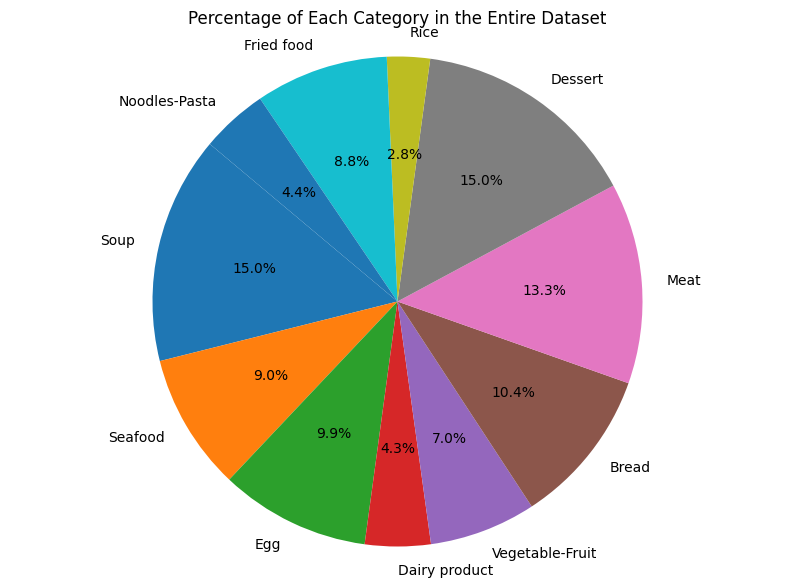

In [ ]:
import os
import matplotlib.pyplot as plt

def walk_through_count(dir_path):
    """Walks through dir_path and returns a dictionary with category names and their image counts."""
    category_counts = {}
    for dirpath, dirnames, filenames in os.walk(dir_path):
        if not dirnames:  # Only interested in leaf directories containing images
            category_name = os.path.basename(dirpath)
            category_counts[category_name] = len(filenames)
    return category_counts

# Paths to the dataset paths
training_path = "/content/food11-image-dataset/training"
validation_path = "/content/food11-image-dataset/validation"
evaluation_path = "/content/food11-image-dataset/evaluation"

# Get image counts
training_counts = walk_through_count(training_path)
validation_counts = walk_through_count(validation_path)
evaluation_counts = walk_through_count(evaluation_path)

# Aggregate all counts
total_counts = {}
for counts in [training_counts, validation_counts, evaluation_counts]:
    for category, count in counts.items():
        if category in total_counts:
            total_counts[category] += count
        else:
            total_counts[category] = count

# Calculate percentages
total_images = sum(total_counts.values())
percentages = {category: (count / total_images) * 100 for category, count in total_counts.items()}

# Plotting
categories = list(percentages.keys())
percent_values = list(percentages.values())

plt.figure(figsize=(10, 7))
plt.pie(percent_values, labels=categories, autopct='%1.1f%%', startangle=140)
plt.title('Percentage of Each Category in the Entire Dataset')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

# 2.Becoming one with the data (data preparation and data exploration)

In [ ]:
import os
def walk_through_dir(dir_path):
  """Walks through dir_path returning its contents."""
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'. ")

In [ ]:
image_path = "/content/food11-image-dataset"

In [ ]:
walk_through_dir(image_path)

There are 3 directories and 0 images in '/content/food11-image-dataset'. 
There are 11 directories and 0 images in '/content/food11-image-dataset/training'. 
There are 0 directories and 440 images in '/content/food11-image-dataset/training/Noodles-Pasta'. 
There are 0 directories and 280 images in '/content/food11-image-dataset/training/Rice'. 
There are 0 directories and 855 images in '/content/food11-image-dataset/training/Seafood'. 
There are 0 directories and 994 images in '/content/food11-image-dataset/training/Bread'. 
There are 0 directories and 429 images in '/content/food11-image-dataset/training/Dairy product'. 
There are 0 directories and 1325 images in '/content/food11-image-dataset/training/Meat'. 
There are 0 directories and 986 images in '/content/food11-image-dataset/training/Egg'. 
There are 0 directories and 709 images in '/content/food11-image-dataset/training/Vegetable-Fruit'. 
There are 0 directories and 1500 images in '/content/food11-image-dataset/training/Soup'.

In [ ]:
from pathlib import Path
image_path = Path(image_path)

# Setup training and testing and validation paths
train_dir = image_path / "training"
validation_dir = image_path / "validation"
test_dir = image_path / "evaluation"

train_dir, test_dir, validation_dir

(PosixPath('/content/food11-image-dataset/training'),
 PosixPath('/content/food11-image-dataset/evaluation'),
 PosixPath('/content/food11-image-dataset/validation'))

In [ ]:
import os

# Count the number of files in train directory
train_files = os.listdir(train_dir)
num_train_files = len(train_files)
print("Number of files in train directory:", num_train_files)

# Count the number of files in validation directory
validation_files = os.listdir(validation_dir)
num_validation_files = len(validation_files)
print("Number of files in test directory:", num_validation_files)

# Count the number of files in test directory
test_files = os.listdir(test_dir)
num_test_files = len(test_files)
print("Number of files in test directory:", num_test_files)

Number of files in train directory: 11
Number of files in test directory: 11
Number of files in test directory: 11


In [ ]:
import os

def count_images_in_directory(directory):
    num_images = 0
    for root, dirs, files in os.walk(directory):
        for file in files:
            # Check if the file is an image file (e.g., jpg, png, etc.)
            if file.lower().endswith(('.png', '.jpg', '.jpeg', '.gif', '.bmp')):
                num_images += 1
    return num_images

# Count the number of images in train directory
num_train_images = count_images_in_directory(train_dir)
print("Number of images in train directory:", num_train_images)

# Count the number of images in validation directory
num_validation_images = count_images_in_directory(validation_dir)
print("Number of images in validation directory:", num_validation_images)

# Count the number of images in test directory
num_test_images = count_images_in_directory(test_dir)
print("Number of images in test directory:", num_test_images)

Number of images in train directory: 9866
Number of images in validation directory: 3430
Number of images in test directory: 3347


* Number of images in train directory: 9866

* Number of images in validation directory: 3430

* Number of images in test directory: 3347

### 2.1 Visualising an image

/content/food11-image-dataset/training/Meat/64.jpg
Meat
Random image path: /content/food11-image-dataset/training/Meat/64.jpg
Image class: Meat
Image height: 384
Image width: 512


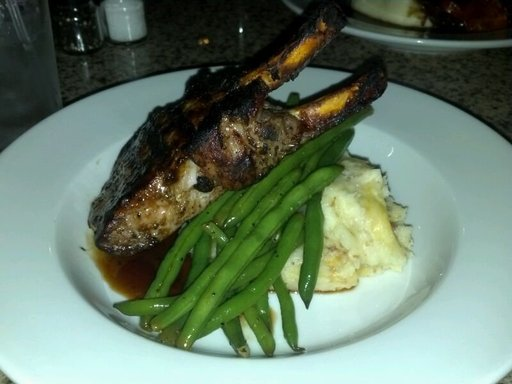

In [ ]:
import random
from PIL import Image

# Set seed
random.seed(42)

# 1. Get all the image paths
image_path_list = list(image_path.glob("*/*/*.jpg"))

# 2. Pick a random image path
random_image_path = random.choice(image_path_list)
print(random_image_path)

# 3. Get image class from path name (the image class is the name of the directory where the image is stored)
image_class = random_image_path.parent.stem
print(image_class)

# 4. Open image with PIL
img = Image.open(random_image_path)

# 5. Print metadata
print(f"Random image path: {random_image_path}")
print(f"Image class: {image_class}")
print(f"Image height: {img.height}")
print(f"Image width: {img.width}")
img

# 3.Transforming data

Before we can use our image data with PyTorch, we will do the following steps:
1. Turn our target data into tensors (in our case, numerical representation of our images).
2. Turn it into a `torch.utils.data.Dataset` and subsequently a `torch.utils.data.DataLoader`, we'll call these `Dataset` and `DataLoader` for short.

Since we're working with a vision problem, we'll be looking at `torchvision.datasets` for our data loading functions as well as `torchvision.transforms` for preparing our data.

In [ ]:
# Importing base libaries
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

## 3.1 Transforming data with `torchvision.transforms`

In [ ]:
# Write a transform for an image
data_transform = transforms.Compose([
    # Resize our images to 256x256
    transforms.Resize(size=(256, 256)),
    # Flipt the images randomly on the horizantal
    transforms.RandomHorizontalFlip(p=0.5), # p = probability of flip on the horizantal axis
    # Turn the image into a torch.Tensor
    transforms.ToTensor()
])

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# show some samples
def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

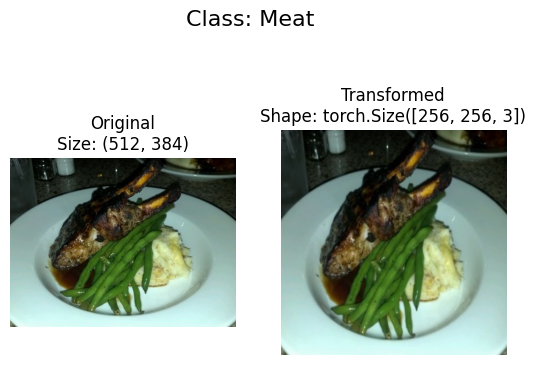

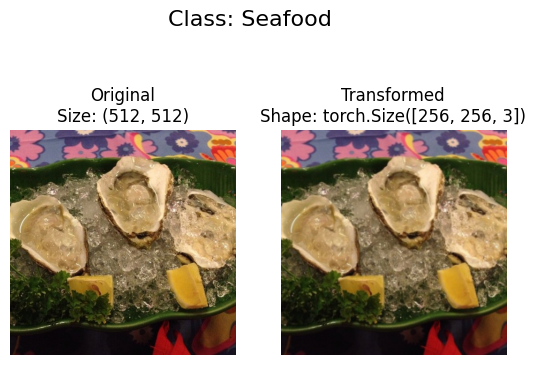

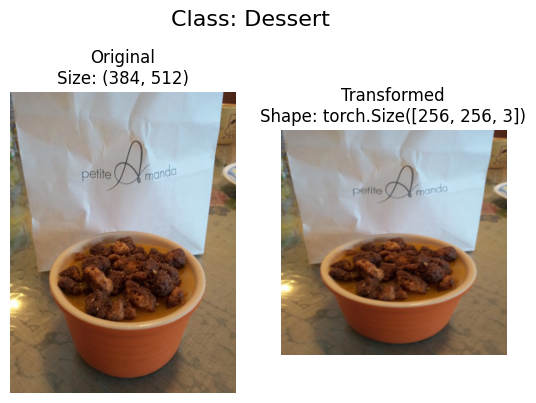

In [ ]:
def plot_transformed_images(image_paths: list,
                            transform,
                            n=3,
                            seed=None):
  """
  Selects random images from a path of images and loads/transforms them
  then plots the original vs the transformed version.

  It will open n=3 image paths from image_paths, transform them with transform
  and plot them side by side.
  """
  if seed:
    random.seed(seed)
  random_image_paths = random.sample(image_paths, k=n)
  for image_path in random_image_paths:
    with Image.open(image_path) as f:
      fig, ax = plt.subplots(nrows=1, ncols=2)
      ax[0].imshow(f)
      ax[0].set_title(f"Original\nSize: {f.size}")
      ax[0].axis(False)

      # Transform and plot target image
      # Note: permute() will change shape of image to suit matplotlib
      # (PyTorch default is [C, H, W] but Matplotlib is [H, W, C])
      transformed_image = transform(f).permute(1, 2, 0) # note we will need to change shape for matplotlib (C,H,W) -> (H, W, C)
      ax[1].imshow(transformed_image)
      ax[1].set_title(f"Transformed\nShape: {transformed_image.shape}")
      ax[1].axis(False)

      fig.suptitle(f"Class: {image_path.parent.stem}", fontsize=16)

plot_transformed_images(image_paths=image_path_list,
                        transform=data_transform,
                        n=3,
                        seed=42)

# 4.Loading image data using `ImageFolder`

Since our data is in standard image classification format, we can load image classification data using `torchvision.datasets.ImageFolder`

In [ ]:
# Use ImageFolder to create datasets
from torchvision import datasets

train_data = datasets.ImageFolder(root=train_dir,
                                  transform=data_transform,
                                  target_transform=None)

test_data = datasets.ImageFolder(root=test_dir,
                                 transform=data_transform)

validation_data = datasets.ImageFolder(root=validation_dir,
                                 transform=data_transform)

train_data, validation_data, test_data

(Dataset ImageFolder
     Number of datapoints: 9866
     Root location: /content/food11-image-dataset/training
     StandardTransform
 Transform: Compose(
                Resize(size=(256, 256), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 3430
     Root location: /content/food11-image-dataset/validation
     StandardTransform
 Transform: Compose(
                Resize(size=(256, 256), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 3347
     Root location: /content/food11-image-dataset/evaluation
     StandardTransform
 Transform: Compose(
                Resize(size=(256, 256), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.5)
                ToTensor()


Let's inspect the `Dataset`s by checking out the `classes` and `class_to_idx` attributes as well as the lengths of our training and validation sets.

In [ ]:
# Get class names as a list
class_names = train_data.classes
class_names

['Bread',
 'Dairy product',
 'Dessert',
 'Egg',
 'Fried food',
 'Meat',
 'Noodles-Pasta',
 'Rice',
 'Seafood',
 'Soup',
 'Vegetable-Fruit']

In [ ]:
# Get class names as a directory
class_dict = train_data.class_to_idx
class_dict

{'Bread': 0,
 'Dairy product': 1,
 'Dessert': 2,
 'Egg': 3,
 'Fried food': 4,
 'Meat': 5,
 'Noodles-Pasta': 6,
 'Rice': 7,
 'Seafood': 8,
 'Soup': 9,
 'Vegetable-Fruit': 10}

In [ ]:
# Check the lengths of our dataset
len(train_data), len(test_data), len(validation_data)

(9866, 3347, 3430)

We will use the above information to reference for later.

Now how do the images and labels look like? We can index on our `train_data` and `validation_data` `Datasets`s to find samples and their target labels.

In [ ]:
# Index on the train_data dataset to get a single image and label
img, label= train_data[0][0], train_data[0][1]
print(f"Image tensor:\n{img}")
print(f"Image shape: {img.shape}")
print(f"Image datatype: {img.dtype}")
print(f"Image label: {label}")
print(f"Label datatype: {type(label)}")

Image tensor:
tensor([[[0.7412, 0.7412, 0.7412,  ..., 0.8275, 0.8275, 0.8235],
         [0.7412, 0.7373, 0.7373,  ..., 0.8353, 0.8353, 0.8392],
         [0.7451, 0.7412, 0.7373,  ..., 0.8471, 0.8431, 0.8431],
         ...,
         [0.2510, 0.2549, 0.2627,  ..., 0.9098, 0.9137, 0.8980],
         [0.2588, 0.2588, 0.2627,  ..., 0.9098, 0.9176, 0.9216],
         [0.2510, 0.2549, 0.2745,  ..., 0.8902, 0.9059, 0.9176]],

        [[0.8235, 0.8235, 0.8235,  ..., 0.8667, 0.8627, 0.8588],
         [0.8235, 0.8196, 0.8157,  ..., 0.8667, 0.8627, 0.8667],
         [0.8196, 0.8157, 0.8118,  ..., 0.8667, 0.8627, 0.8667],
         ...,
         [0.2588, 0.2627, 0.2706,  ..., 0.9686, 0.9725, 0.9569],
         [0.2667, 0.2667, 0.2706,  ..., 0.9686, 0.9765, 0.9804],
         [0.2588, 0.2627, 0.2824,  ..., 0.9490, 0.9647, 0.9765]],

        [[0.9922, 0.9922, 0.9922,  ..., 0.9647, 0.9647, 0.9608],
         [0.9922, 0.9882, 0.9843,  ..., 0.9725, 0.9725, 0.9765],
         [0.9843, 0.9804, 0.9765,  ..., 0.98

Our images are now in the form of a tensor (with shape [3, 256, 256]) and the labels are in the form of an integer relating to a specific class (as referenced by the `class_to_idx` attribute).

Now we will plot a single image tensor using `matplotlib`. To do this, we first have to permute (rearrange the order of its dimensions) so it's compatible.

Right now our image dimensions are in the format CHW (colour channels, height, width) but `matplotlib` prefers HWC (heigh, width, colour channels).

Original shape: torch.Size([3, 256, 256]) -> [colour_channels, height, width]
Image permute: torch.Size([256, 256, 3]) -> [height, width, colour_channels]


Text(0.5, 1.0, 'Bread')

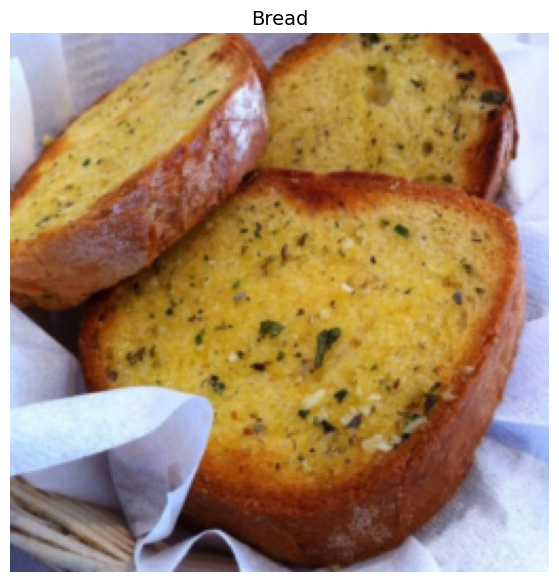

In [ ]:
# Rearrange the order of dimensions (matplotlib likes colour channels last!)
img_permute = img.permute(1, 2, 0)

# Print out different shapes (before and after permute)
print(f"Original shape: {img.shape} -> [colour_channels, height, width]")
print(f"Image permute: {img_permute.shape} -> [height, width, colour_channels]")

# Plot the image
plt.figure(figsize=(10, 7))
plt.imshow(img_permute)
plt.axis(False)
plt.title(class_names[label], fontsize=14)

### 4.1 Turn loaded images into `DataLoader`s

We will turn our data into `DataLoader` so we can turn our data into iterables or batchify our data.

In [ ]:
import os
os.cpu_count()

2

In [ ]:
# Turn train, test and validation datasets into DataLoaders
from torch.utils.data import DataLoader
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()

train_dataloader = DataLoader(dataset=train_data,
                              batch_size=BATCH_SIZE,
                              num_workers=NUM_WORKERS,
                              shuffle=True)

validation_dataloader = DataLoader(dataset=validation_data,
                             batch_size=BATCH_SIZE,
                             num_workers=NUM_WORKERS,
                             shuffle=False) # don't usually need to shuffle validation data

test_dataloader = DataLoader(dataset=test_data,
                             batch_size=BATCH_SIZE,
                             num_workers=NUM_WORKERS,
                             shuffle=False) # don't usually need to shuffle testing data

train_dataloader, test_dataloader, validation_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7b720071fca0>,
 <torch.utils.data.dataloader.DataLoader at 0x7b720071fa90>)

In [ ]:
print(f"Length of train_dataloader: {len(train_dataloader)}, Length of test_dataloader: {len(test_dataloader)}, Length of validation_dataloader: {len(validation_dataloader)}")
print(f"Length of train_data: {len(train_data)}, length of test_data: {len(test_data)}, length of validation_data: {len(validation_data)}")

Length of train_dataloader: 309, Length of test_dataloader: 105, Length of validation_dataloader: 108
Length of train_data: 9866, length of test_data: 3347, length of validation_data: 3430


* Length of train_dataloader: 309, Length of test_dataloader: 105, Length of validation_dataloader: 108
* Length of train_data: 9866, length of test_data: 3347, length of validation_data: 3430

Note how much the batch_size alters the length of our datasets.

In [ ]:
img, label = next(iter(train_dataloader))

print(f"Image shape: {img.shape} -> [batch_size, colour_channels, height, width]")
print(f"Label shape: {label.shape}")

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Image shape: torch.Size([32, 3, 256, 256]) -> [batch_size, colour_channels, height, width]
Label shape: torch.Size([32])


We can now use these `DataLoader`s with a training and testing loop to train a model.

However we'd like to also try to use another form of transforms: data augmentation.

In [ ]:
# Get all the image paths
image_path_list = list(image_path.glob("*/*/*.jpg"))
image_path_list[:10]

[PosixPath('/content/food11-image-dataset/training/Noodles-Pasta/216.jpg'),
 PosixPath('/content/food11-image-dataset/training/Noodles-Pasta/73.jpg'),
 PosixPath('/content/food11-image-dataset/training/Noodles-Pasta/407.jpg'),
 PosixPath('/content/food11-image-dataset/training/Noodles-Pasta/308.jpg'),
 PosixPath('/content/food11-image-dataset/training/Noodles-Pasta/153.jpg'),
 PosixPath('/content/food11-image-dataset/training/Noodles-Pasta/202.jpg'),
 PosixPath('/content/food11-image-dataset/training/Noodles-Pasta/168.jpg'),
 PosixPath('/content/food11-image-dataset/training/Noodles-Pasta/11.jpg'),
 PosixPath('/content/food11-image-dataset/training/Noodles-Pasta/264.jpg'),
 PosixPath('/content/food11-image-dataset/training/Noodles-Pasta/179.jpg')]

# 6.Get datasets and transformations ready

## 6.0 Create transform with data augmentation (Trivial)

In [ ]:
# Let's try out TrivialAugment
from torchvision import transforms

# Create training transform with TrivialAugment
train_transform_trivial = transforms.Compose([
    transforms.Resize(size=(256, 256)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31),
    transforms.ToTensor()
])

# Create testing transform (no data augmentation)
# and we will use this one both the test and the validation sets
test_transform_simple = transforms.Compose([
    transforms.Resize(size=(256, 256)),
    transforms.ToTensor()
])

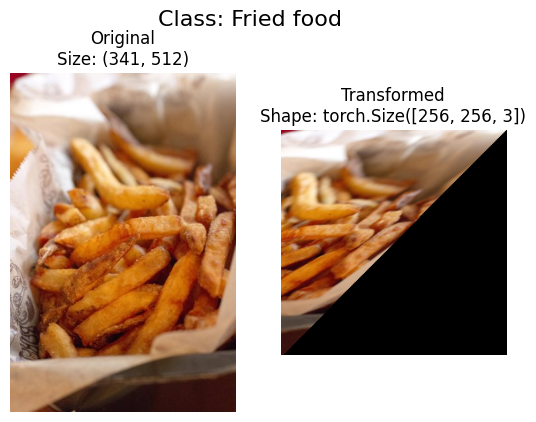

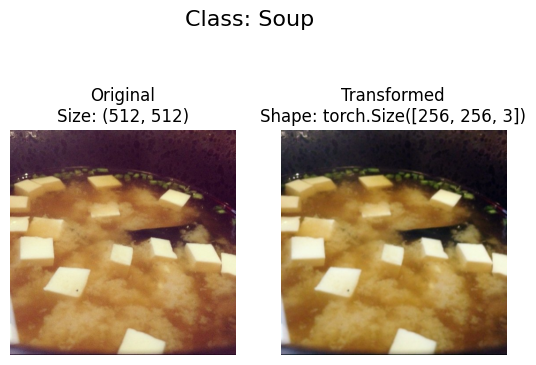

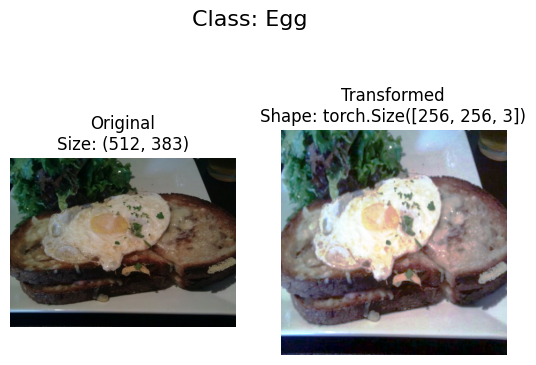

In [ ]:
# Plot random transformed images
plot_transformed_images(
    image_paths=image_path_list,
    transform=train_transform_trivial,
    n=3,
    seed=None
)

## 6.4 Create train, test and validation `Dataset`s and `DataLoader`s with data augmentation

We'll make sure the train `Dataset` uses the `train_transform_trivial` and the test and validation `Dataset`s uses the `test_transform_simple`.

In [ ]:
# Turn image folders into Datasets
from torchvision import datasets
train_data_augmented = datasets.ImageFolder(root=train_dir,
                                            transform=train_transform_trivial)

validation_data_simple = datasets.ImageFolder(root=validation_dir,
                                        transform=test_transform_simple)

test_data_simple = datasets.ImageFolder(root=test_dir,
                                        transform=test_transform_simple)

In [ ]:
# Turn our Datasets into DataLoaders
import os
from torch.utils.data import DataLoader
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()

print(f"Creating DataLoader's with batch size {BATCH_SIZE} and {NUM_WORKERS} workers.")

torch.manual_seed(42)

train_dataloader_augmented = DataLoader(dataset=train_data_augmented,
                                        batch_size=BATCH_SIZE,
                                        num_workers=NUM_WORKERS,
                                        shuffle=True)

validation_dataloader_simple = DataLoader(dataset=validation_data_simple,
                                    batch_size=BATCH_SIZE,
                                    num_workers=NUM_WORKERS,
                                    shuffle=False)

test_dataloader_simple = DataLoader(dataset=test_data_simple,
                                    batch_size=BATCH_SIZE,
                                    num_workers=NUM_WORKERS,
                                    shuffle=False)

Creating DataLoader's with batch size 32 and 2 workers.


Now that we've got our model and dataloader, let's create a loss function and an optimiser and call upon our `train()` function to train and evaluate our model.

## 6.2 Create train and test loop functions

(We will need this for next step)

* `train_step()` - takes in a model and dataloader and trains the model on the dataloader
* `test_step()` - takes in a model and dataloader and evaluates the model on the dataloader

In [ ]:
# Create train_step()
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimiser: torch.optim.Optimizer,
               device=device):
  # Put the model in train mode
  model.train()

  # Setup train loss and train accuracy values (per batch)
  train_loss, train_acc = 0, 0

  # Loop through data loader data batches
  for batch, (X, y) in enumerate(dataloader):
    # Send data to the target device
    X, y = X.to(device), y.to(device)

    # 1. Forward pass
    y_pred = model(X) # outputs model logits

    # 2. Calculate the loss
    loss = loss_fn(y_pred, y)
    train_loss += loss.item()

    # 3. Optimiser zero grad
    optimiser.zero_grad()

    # 4. Loss backward
    loss.backward()

    # 5. Optimiser step
    optimiser.step()

    # Calculate and accumulate accuracy metric across all batches
    y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
    train_acc += (y_pred_class==y).sum().item()/len(y_pred)

  # Adjust metrics to get the average loss and accuracy per batch
  train_loss = train_loss / len(dataloader)
  train_acc = train_acc / len(dataloader)
  return train_loss, train_acc

In [ ]:
# Create test_step()
def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              device=device):
  # Put model in eval mode
  model.eval()

  # Setup test loss and test accuracy values
  test_loss, test_acc = 0, 0

  # Turn on inference mode
  with torch.inference_mode():
    # Loop through DataLoader batches
    for batch, (X, y) in enumerate(dataloader):
      # Send data to the target device
      X, y = X.to(device), y.to(device)

      # 1. Forward pass
      test_pred_logits = model(X)

      # 2. Calculate and accumulate loss
      loss = loss_fn(test_pred_logits, y)
      test_loss += loss.item()

      # Calculate and accumulate accuracy
      test_pred_labels = test_pred_logits.argmax(dim=1)
      test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))

    # Adjust the metrics to get average loss and accuracy per batch
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc

## 6.3 Creating a `train()` function to combine `train_step()` and `test_step()`

This function will train the model as well as evaluate it.

In [ ]:
from tqdm.auto import tqdm

# 1. Create a train function that takes in various model parameters + optimiser + dataloaders + loss function
def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimiser: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(), # we will set this loss function since it's a multi-class classification problem
          epochs: int = 5,
          device=device):

  # 2. Create an empty results dictionary (to help us track our results)
  results = {"train_loss": [],
             "train_acc": [],
             "test_loss": [],
             "test_acc": []}

  # 3. Loop through training and testing steps for a number of epochs
  for epoch in tqdm(range(epochs)):
    train_loss, train_acc = train_step(model=model,
                                       dataloader=train_dataloader_augmented,
                                       loss_fn=loss_fn,
                                       optimiser=optimiser,
                                       device=device)

    test_loss, test_acc = test_step(model=model,
                                    dataloader=test_dataloader_simple,
                                    loss_fn=loss_fn,
                                    device=device)

    # 4. Print out what's happening
    print(f"Epoch: {epoch} | Train loss: {train_loss:.4f} | Train acc: {train_acc:.4f} | Test loss: {test_loss:.4f} | Test acc: {test_acc:.4f}")

    # 5. Update results dictionary
    results["train_loss"].append(train_loss)
    results["train_acc"].append(train_acc)
    results["test_loss"].append(test_loss)
    results["test_acc"].append(test_acc)


  # 6. Return the filled results at the end of the epochs loop
  return results

# 7.Model building

We will do the training process and model building on the validation set to pick the best model for our classification task.

## 7.0 Function for plotting loss curves

In [ ]:
from typing import Tuple, Dict, List

def plot_loss_curves(results: Dict[str, List[float]]):
  """
  Plots training curves of a results dictionary.

  Args:
        results (dict): dictionary containing list of values, e.g.
            {"train_loss": [...],
             "train_acc": [...],
             "test_loss": [...],
             "test_acc": [...]}
  """
  # Get the loss values of the results dictionary (training and test)
  loss = results["train_loss"]
  test_loss = results["test_loss"]

  # Get the accuracy values of the results dictionary (training and test)
  accuracy = results["train_acc"]
  test_accuracy = results["test_acc"]

  # Figure out how many epochs there were
  epochs = range(len(results["train_loss"]))

  # Setup a plot
  plt.figure(figsize=(15, 7))

  # Plot the loss
  plt.subplot(1, 2, 1)
  plt.plot(epochs, loss, label="train_loss")
  plt.plot(epochs, test_loss, label="test_loss")
  plt.title("Loss")
  plt.xlabel("Epochs")
  plt.legend()

  # Plot the accuracy
  plt.subplot(1, 2, 2)
  plt.plot(epochs, accuracy, label="train_accuracy")
  plt.plot(epochs, test_accuracy, label="test_accuracy")
  plt.title("Accuracy")
  plt.xlabel("Epochs")
  plt.legend();

In [ ]:
# Install torchinfo, import it if it's available
try:
  import torchinfo
except:
  !pip install torchinfo
  import torchinfo

from torchinfo import summary

## 7.1 `Model_1`: TinyVGG with data augmentation

### 7.1.1 Create TinyVGG model class

In [ ]:
class TinyVGG(nn.Module):
  """
  Model architecture copying TinyVGG from CNN Explainer:
  https://poloclub.github.io/cnn-explainer/
  """
  def __init__(self,
               input_shape: int,
               hidden_units: int,
               output_shape: int) -> None:
    super().__init__()

    self.conv_block_1 = nn.Sequential(
        nn.Conv2d(in_channels=input_shape,
                  out_channels=hidden_units,
                  kernel_size=3, # how big is the square that's going over the image?
                  stride=1, # default
                  padding=0),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=0),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2,
                     stride=2) # default stride value is the same as the kernel size
    )

    self.conv_block_2 = nn.Sequential(
        nn.Conv2d(in_channels=hidden_units, # this is the only difference between block 1 and 2!
                  out_channels=hidden_units,
                  kernel_size=3, # how big is the square that's going over the image?
                  stride=1, # default
                  padding=0),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=0),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2,
                     stride=2) # default stride value is the same as the kernel size
    )

    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=hidden_units*61*61,
                  out_features=output_shape)
    )

  def forward(self, x):
    x = self.conv_block_1(x)
    # print(x.shape)
    x=self.conv_block_2(x)
    # print(x.shape)
    x = self.classifier(x)
    # print(x.shape)
    return x

### 7.1.2 Construct and train `model_1`

In [ ]:
# Create model_1 and send it to the target device
torch.manual_seed(42)

model_1 = TinyVGG(input_shape=3,
                  hidden_units=10,
                  output_shape=len(train_data_augmented.classes)).to(device)

model_1

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=37210, out_features=11, bias=True)
  )
)

In [ ]:
# Set random seed
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set the number of epochs
NUM_EPOCHS = 5

# Setup loss function
loss_fn = nn.CrossEntropyLoss()

optimiser = torch.optim.Adam(params=model_1.parameters(),
                             lr=0.001) # the default for Adam

# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Train model_1
model_1_results = train(model=model_1,
                        train_dataloader=train_dataloader_augmented,
                        test_dataloader=validation_dataloader_simple,
                        optimiser=optimiser,
                        loss_fn=loss_fn,
                        epochs=NUM_EPOCHS,
                        device=device)

# End timer and print out how long it took
end_time = timer()
print(f"[INFO] Total training time for model_1: {end_time-start_time:.3f} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 0 | Train loss: 2.2953 | Train acc: 0.1614 | Test loss: 2.2460 | Test acc: 0.1926
Epoch: 1 | Train loss: 2.2275 | Train acc: 0.1953 | Test loss: 2.2013 | Test acc: 0.1946
Epoch: 2 | Train loss: 2.2022 | Train acc: 0.2092 | Test loss: 2.1483 | Test acc: 0.2176
Epoch: 3 | Train loss: 2.1821 | Train acc: 0.2103 | Test loss: 2.1433 | Test acc: 0.2222
Epoch: 4 | Train loss: 2.1605 | Train acc: 0.2181 | Test loss: 2.1180 | Test acc: 0.2252
[INFO] Total training time for model_1: 411.449 seconds


### 7.1.3 Use `torchinfo` to get an idea of the shapes going through our model



In [ ]:
summary(model_1, input_size=[1, 3, 256, 256]) # do a test pass through of an example input size

Layer (type:depth-idx)                   Output Shape              Param #
TinyVGG                                  [1, 11]                   --
├─Sequential: 1-1                        [1, 10, 126, 126]         --
│    └─Conv2d: 2-1                       [1, 10, 254, 254]         280
│    └─ReLU: 2-2                         [1, 10, 254, 254]         --
│    └─Conv2d: 2-3                       [1, 10, 252, 252]         910
│    └─ReLU: 2-4                         [1, 10, 252, 252]         --
│    └─MaxPool2d: 2-5                    [1, 10, 126, 126]         --
├─Sequential: 1-2                        [1, 10, 61, 61]           --
│    └─Conv2d: 2-6                       [1, 10, 124, 124]         910
│    └─ReLU: 2-7                         [1, 10, 124, 124]         --
│    └─Conv2d: 2-8                       [1, 10, 122, 122]         910
│    └─ReLU: 2-9                         [1, 10, 122, 122]         --
│    └─MaxPool2d: 2-10                   [1, 10, 61, 61]           --
├─Sequentia

### 7.1.4 Plot the loss curves of model_1

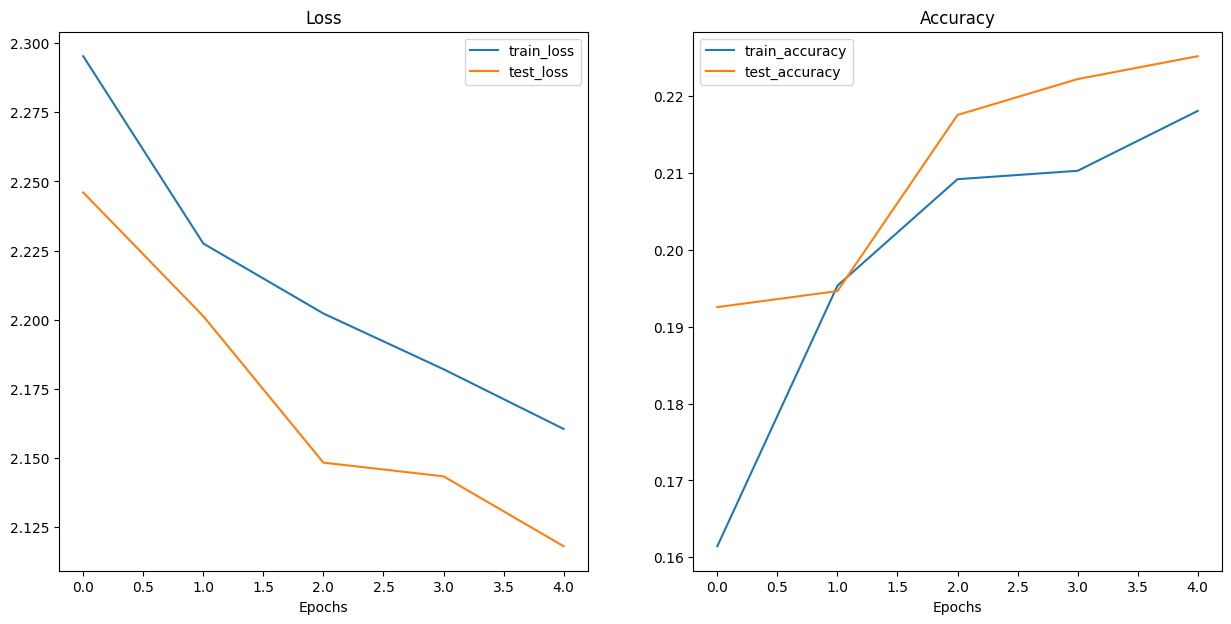

In [ ]:
# Let's test our plot_loss_curves() function out.
plot_loss_curves(model_1_results)

## 7.2 Model_2: EfficientNet_B7

https://pytorch.org/vision/0.17/models/generated/torchvision.models.efficientnet_b0.html#torchvision.models.efficientnet_b0

We will use pretrained models (transfer learing techniques).

There are different versions of this particular model (up to EfficientNet_B7). The higher the version, the better the performance might be. On the other hand, the higher the version, the bigger and more complex the model will be.

However, in light of The Bitter Lesson, if we had infinite compute, we'd likely pick the biggest + most parameters + most general we could - http://www.incompleteideas.net/IncIdeas/BitterLesson.html


In [ ]:
import torchvision

# Setup the model with pretrained weights and send it to the target device
weights = torchvision.models.EfficientNet_B7_Weights.DEFAULT # .DEFAULT = best available weights
model_2 = torchvision.models.efficientnet_b7(weights=weights).to(device)

# Let's have a quick look at the model
model_2

Downloading: "https://download.pytorch.org/models/efficientnet_b7_lukemelas-c5b4e57e.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b7_lukemelas-c5b4e57e.pth
100%|██████████| 255M/255M [00:01<00:00, 136MB/s]


EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=64, bias=False)
            (1): BatchNorm2d(64, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(64, 16, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormAct

Our `efficientnet_b0` comes in three main parts:

* `features` - A collection of convolutional layers and other various activation layers to learn a base representation of vision data (this base representation/collection of layers is often referred to as features or feature extractor, "the base layers of the model learn the different features of images").

* `avgpool` - Takes the average of the output of the features layer(s) and turns it into a single feature vector (which will be of size 1280 in our case, since `in_features=1280` in the last layer).

* `classifier` - Turns the feature vector into a vector with the same dimensionality as the number of required output classes (since `efficientnet_b0` is pretrained on `ImageNet` and because `ImageNet` has 1000 classes, `out_features=1000` is the default). NOTE: obviously we need to change this to 3 since we've only got 3 different classes (pizza, steak or sushi).


**Kinds of transfer learning:**

* Original model ("As is"): Take a pretrained model as it is and apply it to your task without any changes.
  * What happens? The model **remains unchanged**.
  * When to use? If you have the **exact same kind of data** the original model was trained on.

* Feature extraction: Take the underlying patterns (also called weights) a pretrained model has learned and adjust its outputs to be more suited to your problem.
  * What happens? **Most of the layers** in the original model **remain frozen** during training (only the top 1-3 layers get updated).
  * When to use? If you have a **small amount of custom data** (similar to what the original model was trained on) and want to utilise a pretrained model to get **better results on you specific problem**.

* Fine-tuning: Take the weights of a pretrained model and adjust (fine-tune) them to your own problem.
  * What happens? **Some, many or all** of the layers in the pretrained model **are updated** during training.
  * When to use? If you have a **large amount of custom data** and want to utilise a pretrained model and improve its underlying patterns to your specific problem.

*We will use **Feature extraction** in our case!*

Before using feature extraction though, let's just get a summary of our model:

In [ ]:
# Print a summary of our model using torchinfo
summary(model=model_2,
        input_size=(32, 3, 256, 256), # [batch_size, colour_channels, height, width]
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 256, 256]    [32, 1000]           --                   True
├─Sequential (features)                                      [32, 3, 256, 256]    [32, 2560, 8, 8]     --                   True
│    └─Conv2dNormActivation (0)                              [32, 3, 256, 256]    [32, 64, 128, 128]   --                   True
│    │    └─Conv2d (0)                                       [32, 3, 256, 256]    [32, 64, 128, 128]   1,728                True
│    │    └─BatchNorm2d (1)                                  [32, 64, 128, 128]   [32, 64, 128, 128]   128                  True
│    │    └─SiLU (2)                                         [32, 64, 128, 128]   [32, 64, 128, 128]   --                   --
│    └─Sequential (1)                                        [32, 64, 128, 128]   [32, 32, 128

**Freezing the base model and changing the output layer to suit our needs:**

With a feature extractor model, typically we will *freeze* the base layers of a pretrained model and update the output layers to suit our problem.

In [ ]:
# Freeze all base layers in the "features" section of the model (the feature extractor) by setting requires_grad=False
for param in model_2.features.parameters():
    param.requires_grad = False

In [ ]:
# Set the manual seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Get the length of class_names (one output unit for each class)
output_shape = len(class_names)

# Recreate the classifier layer to update the output dimension and seed it to the target device
model_2.classifier = torch.nn.Sequential(
    torch.nn.Dropout(p=0.2, inplace=True),
    torch.nn.Linear(in_features=2560,
                    out_features=output_shape, # same number of output units as our number of classes
                    bias=True)).to(device)

# Let's have a look
model_2.classifier

Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=2560, out_features=11, bias=True)
)

In [ ]:
# Do a summary *after* freezing the features and changing the output classifier layer (uncomment for actual output)
summary(model_2,
        input_size=(32, 3, 256, 256), # make sure this is "input_size", not "input_shape" (batch_size, color_channels, height, width)
        verbose=0,
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 256, 256]    [32, 11]             --                   Partial
├─Sequential (features)                                      [32, 3, 256, 256]    [32, 2560, 8, 8]     --                   False
│    └─Conv2dNormActivation (0)                              [32, 3, 256, 256]    [32, 64, 128, 128]   --                   False
│    │    └─Conv2d (0)                                       [32, 3, 256, 256]    [32, 64, 128, 128]   (1,728)              False
│    │    └─BatchNorm2d (1)                                  [32, 64, 128, 128]   [32, 64, 128, 128]   (128)                False
│    │    └─SiLU (2)                                         [32, 64, 128, 128]   [32, 64, 128, 128]   --                   --
│    └─Sequential (1)                                        [32, 64, 128, 128]   [32, 

In [ ]:
# Define loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_2.parameters(), lr=0.001)

# Set the random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set the number of epochs
NUM_EPOCHS = 5

# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Setup training and save the results
model_2_results = train(model=model_2,
                       train_dataloader=train_dataloader_augmented,
                       test_dataloader=validation_dataloader_simple,
                       optimiser=optimizer,
                       loss_fn=loss_fn,
                       epochs=NUM_EPOCHS,
                       device=device)

# End the timer and print out how long it took
end_time = timer()
print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 0 | Train loss: 1.4635 | Train acc: 0.5869 | Test loss: 0.9796 | Test acc: 0.7284
Epoch: 1 | Train loss: 1.0518 | Train acc: 0.6720 | Test loss: 0.8298 | Test acc: 0.7577
Epoch: 2 | Train loss: 0.9597 | Train acc: 0.6982 | Test loss: 0.7694 | Test acc: 0.7695
Epoch: 3 | Train loss: 0.9000 | Train acc: 0.7113 | Test loss: 0.7417 | Test acc: 0.7725
Epoch: 4 | Train loss: 0.8880 | Train acc: 0.7113 | Test loss: 0.7202 | Test acc: 0.7782
[INFO] Total training time: 840.685 seconds


## 7.3 Model_3: AlexNet

https://pytorch.org/vision/0.17/models/generated/torchvision.models.alexnet.html#torchvision.models.alexnet

In [ ]:
import torchvision

# Setup the model with pretrained weights and send it to the target device
weights = torchvision.models.AlexNet_Weights.DEFAULT # .DEFAULT = best available weights
model_3 = torchvision.models.alexnet(weights=weights).to(device)

# Let's have a quick look at the model
model_3

Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:01<00:00, 157MB/s]


AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [ ]:
# Print a summary using torchinfo
summary(model=model_3,
        input_size=(32, 3, 256, 256), # make sure this is "input_size", not "input_shape"
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
AlexNet (AlexNet)                        [32, 3, 256, 256]    [32, 1000]           --                   True
├─Sequential (features)                  [32, 3, 256, 256]    [32, 256, 7, 7]      --                   True
│    └─Conv2d (0)                        [32, 3, 256, 256]    [32, 64, 63, 63]     23,296               True
│    └─ReLU (1)                          [32, 64, 63, 63]     [32, 64, 63, 63]     --                   --
│    └─MaxPool2d (2)                     [32, 64, 63, 63]     [32, 64, 31, 31]     --                   --
│    └─Conv2d (3)                        [32, 64, 31, 31]     [32, 192, 31, 31]    307,392              True
│    └─ReLU (4)                          [32, 192, 31, 31]    [32, 192, 31, 31]    --                   --
│    └─MaxPool2d (5)                     [32, 192, 31, 31]    [32, 192, 15, 15]    --                   --
│    └─Conv2d (6)     

In [ ]:
# Freeze all base layers in the "features" section of the model (the feature extractor) by setting requires_grad=False
for param in model_3.features.parameters():
    param.requires_grad = False

In [ ]:
# Set the manual seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Get the length of class_names (one output unit for each class)
output_shape = len(class_names)

# Recreate the classifier layer and seed it to the target device
model_3.classifier = torch.nn.Sequential(
    torch.nn.Dropout(p=0.2),
    torch.nn.Linear(in_features=9216,
                    out_features=4096, # same number of output units as our number of classes
                    bias=True),
    torch.nn.ReLU(),
    torch.nn.Dropout(p=0.2),
    torch.nn.Linear(in_features=4096,
                    out_features=4096, # same number of output units as our number of classes
                    bias=True),
    torch.nn.ReLU(),
    torch.nn.Linear(in_features=4096,
                    out_features=output_shape, # same number of output units as our number of classes
                    bias=True)).to(device)

# Let's have a look
model_3.classifier

Sequential(
  (0): Dropout(p=0.2, inplace=False)
  (1): Linear(in_features=9216, out_features=4096, bias=True)
  (2): ReLU()
  (3): Dropout(p=0.2, inplace=False)
  (4): Linear(in_features=4096, out_features=4096, bias=True)
  (5): ReLU()
  (6): Linear(in_features=4096, out_features=11, bias=True)
)

In [ ]:
# # Do a summary *after* freezing the features and changing the output classifier layer (uncomment for actual output)
summary(model_3,
        input_size=(32, 3, 256, 256), # make sure this is "input_size", not "input_shape" (batch_size, color_channels, height, width)
        verbose=0,
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
AlexNet (AlexNet)                        [32, 3, 256, 256]    [32, 11]             --                   Partial
├─Sequential (features)                  [32, 3, 256, 256]    [32, 256, 7, 7]      --                   False
│    └─Conv2d (0)                        [32, 3, 256, 256]    [32, 64, 63, 63]     (23,296)             False
│    └─ReLU (1)                          [32, 64, 63, 63]     [32, 64, 63, 63]     --                   --
│    └─MaxPool2d (2)                     [32, 64, 63, 63]     [32, 64, 31, 31]     --                   --
│    └─Conv2d (3)                        [32, 64, 31, 31]     [32, 192, 31, 31]    (307,392)            False
│    └─ReLU (4)                          [32, 192, 31, 31]    [32, 192, 31, 31]    --                   --
│    └─MaxPool2d (5)                     [32, 192, 31, 31]    [32, 192, 15, 15]    --                   --
│    └─Conv2d (6

In [ ]:
# Define loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_3.parameters(), lr=0.001)

# Set the random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

NUM_EPOCHS = 5

# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Setup training and save the results
model_3_results = train(model=model_3,
                       train_dataloader=train_dataloader_augmented,
                       test_dataloader=validation_dataloader_simple,
                       optimiser=optimizer,
                       loss_fn=loss_fn,
                       epochs=NUM_EPOCHS,
                       device=device)

# End the timer and print out how long it took
end_time = timer()
print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 0 | Train loss: 1.6772 | Train acc: 0.4701 | Test loss: 1.0536 | Test acc: 0.6584
Epoch: 1 | Train loss: 1.2860 | Train acc: 0.5706 | Test loss: 0.9909 | Test acc: 0.6745
Epoch: 2 | Train loss: 1.2110 | Train acc: 0.5953 | Test loss: 0.9183 | Test acc: 0.7080
Epoch: 3 | Train loss: 1.1420 | Train acc: 0.6242 | Test loss: 0.9571 | Test acc: 0.6711
Epoch: 4 | Train loss: 1.1069 | Train acc: 0.6363 | Test loss: 0.8701 | Test acc: 0.7137
[INFO] Total training time: 400.985 seconds


## 7.4 Model_4: ResNet50

In [ ]:
import torchvision

# Setup the model with pretrained weights and send it to the target device
weights = torchvision.models.ResNet50_Weights.DEFAULT # .DEFAULT = best available weights
model_4 = torchvision.models.resnet50(weights=weights).to(device)

# Let's have a quick look at the model
model_4

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 174MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
# Print a summary of our model using torchinfo
summary(model=model_4,
        input_size=(32, 3, 256, 256), # [batch_size, colour_channels, height, width]
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
ResNet (ResNet)                          [32, 3, 256, 256]    [32, 1000]           --                   True
├─Conv2d (conv1)                         [32, 3, 256, 256]    [32, 64, 128, 128]   9,408                True
├─BatchNorm2d (bn1)                      [32, 64, 128, 128]   [32, 64, 128, 128]   128                  True
├─ReLU (relu)                            [32, 64, 128, 128]   [32, 64, 128, 128]   --                   --
├─MaxPool2d (maxpool)                    [32, 64, 128, 128]   [32, 64, 64, 64]     --                   --
├─Sequential (layer1)                    [32, 64, 64, 64]     [32, 256, 64, 64]    --                   True
│    └─Bottleneck (0)                    [32, 64, 64, 64]     [32, 256, 64, 64]    --                   True
│    │    └─Conv2d (conv1)               [32, 64, 64, 64]     [32, 64, 64, 64]     4,096                True
│    │    └─BatchN

In [ ]:
# Freeze all base layers in the "layers" section of the model (the feature extractor) by setting requires_grad=False
for param in model_4.layer1.parameters():
    param.requires_grad = False

for param in model_4.layer2.parameters():
    param.requires_grad = False

for param in model_4.layer3.parameters():
    param.requires_grad = False

for param in model_4.layer4.parameters():
    param.requires_grad = False

In [ ]:
# Set the manual seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Get the length of class_names (one output unit for each class)
output_shape = len(class_names)

# Recreate the classifier layer to update the output dimension and seed it to the target device
model_4.fc = torch.nn.Sequential(
    torch.nn.Linear(in_features=2048,
                    out_features=output_shape, # same number of output units as our number of classes
                    bias=True)).to(device)

# Let's have a look
model_4.fc

Sequential(
  (0): Linear(in_features=2048, out_features=11, bias=True)
)

In [ ]:
os.environ["XLA_FLAGS"] = "--xla_force_host_platform_device_count=1"

In [ ]:
# Set the random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Define loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_4.parameters(), lr=0.001)

NUM_EPOCHS = 5

# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Setup training and save the results
model_4_results = train(model=model_4,
                       train_dataloader=train_dataloader_augmented,
                       test_dataloader=validation_dataloader_simple,
                       optimiser=optimizer,
                       loss_fn=loss_fn,
                       epochs=NUM_EPOCHS,
                       device=device)

# End the timer and print out how long it took
end_time = timer()
print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 0 | Train loss: 1.1995 | Train acc: 0.6539 | Test loss: 0.9705 | Test acc: 0.6963
Epoch: 1 | Train loss: 0.7817 | Train acc: 0.7603 | Test loss: 0.6590 | Test acc: 0.8072
Epoch: 2 | Train loss: 0.6653 | Train acc: 0.7943 | Test loss: 0.6429 | Test acc: 0.8278
Epoch: 3 | Train loss: 0.5935 | Train acc: 0.8169 | Test loss: 0.4565 | Test acc: 0.8628
Epoch: 4 | Train loss: 0.5400 | Train acc: 0.8350 | Test loss: 0.5886 | Test acc: 0.8083
[INFO] Total training time: 580.081 seconds


## 7.5 Model_5: RegNet_X_8GF

https://pytorch.org/vision/0.17/models/generated/torchvision.models.regnet_x_8gf.html#torchvision.models.RegNet_X_8GF_Weights

In [ ]:
import torchvision

# Setup the model with pretrained weights and send it to the target device
weights = torchvision.models.RegNet_X_8GF_Weights.DEFAULT # .DEFAULT = best available weights
model_5 = torchvision.models.regnet_x_8gf(weights=weights).to(device)

# Let's have a quick look at the model
model_5

Downloading: "https://download.pytorch.org/models/regnet_x_8gf-2b70d774.pth" to /root/.cache/torch/hub/checkpoints/regnet_x_8gf-2b70d774.pth
100%|██████████| 151M/151M [00:02<00:00, 64.5MB/s]


RegNet(
  (stem): SimpleStemIN(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (trunk_output): Sequential(
    (block1): AnyStage(
      (block1-0): ResBottleneckBlock(
        (proj): Conv2dNormActivation(
          (0): Conv2d(32, 80, kernel_size=(1, 1), stride=(2, 2), bias=False)
          (1): BatchNorm2d(80, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (f): BottleneckTransform(
          (a): Conv2dNormActivation(
            (0): Conv2d(32, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): BatchNorm2d(80, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU(inplace=True)
          )
          (b): Conv2dNormActivation(
            (0): Conv2d(80, 80, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
            (1): Batch

In [ ]:
# Print a summary of our model using torchinfo
summary(model=model_5,
        input_size=(32, 3, 256, 256), # [batch_size, colour_channels, height, width]
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

NameError: name 'summary' is not defined

**Freezing the base model and changing the output layer to suit our needs:**

With a feature extractor model, typically we will *freeze* the base layers of a pretrained model and update the output layers to suit our problem.

In [ ]:
# Freeze all base layers in the "features" section of the model (the feature extractor) by setting requires_grad=False
for param in model_5.stem.parameters():
    param.requires_grad = False

for param in model_5.trunk_output.parameters():
    param.requires_grad = False

In [ ]:
# Set the manual seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Get the length of class_names (one output unit for each class)
output_shape = len(class_names)

# Recreate the classifier layer to update the output dimension and seed it to the target device
model_5.fc = torch.nn.Sequential(
    torch.nn.Linear(in_features=1920,
                    out_features=output_shape, # same number of output units as our number of classes
                    bias=True)).to(device)

# Let's have a look
model_5.fc

Sequential(
  (0): Linear(in_features=1920, out_features=11, bias=True)
)

In [ ]:
# Do a summary *after* freezing the features and changing the output classifier layer (uncomment for actual output)
summary(model_5,
        input_size=(32, 3, 256, 256), # make sure this is "input_size", not "input_shape" (batch_size, color_channels, height, width)
        verbose=0,
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

NameError: name 'summary' is not defined

In [ ]:
# Define loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_5.parameters(), lr=0.001)

# Set the random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set the number of epochs
NUM_EPOCHS = 5

# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Setup training and save the results
model_5_results = train(model=model_5,
                       train_dataloader=train_dataloader_augmented,
                       test_dataloader=validation_dataloader_simple,
                       optimiser=optimizer,
                       loss_fn=loss_fn,
                       epochs=NUM_EPOCHS,
                       device=device)

# End the timer and print out how long it took
end_time = timer()
print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 0 | Train loss: 0.9878 | Train acc: 0.7236 | Test loss: 0.4977 | Test acc: 0.8768
Epoch: 1 | Train loss: 0.5460 | Train acc: 0.8379 | Test loss: 0.3803 | Test acc: 0.8988
Epoch: 2 | Train loss: 0.4614 | Train acc: 0.8600 | Test loss: 0.3422 | Test acc: 0.9057
Epoch: 3 | Train loss: 0.3998 | Train acc: 0.8803 | Test loss: 0.3094 | Test acc: 0.9122
Epoch: 4 | Train loss: 0.3689 | Train acc: 0.8844 | Test loss: 0.2910 | Test acc: 0.9116
[INFO] Total training time: 603.485 seconds


# 8.Compare model results

In [ ]:
import pandas as pd
model_1_df = pd.DataFrame(model_1_results)
model_2_df = pd.DataFrame(model_2_results)
model_3_df = pd.DataFrame(model_3_results)
model_4_df = pd.DataFrame(model_4_results)
model_5_df = pd.DataFrame(model_5_results)

# Display one of the result dataframes as an example
model_1_df

train_loss  train_acc  test_loss  test_acc
0    2.295313   0.161448   2.246006  0.192560
1    2.227542   0.195348   2.201254  0.194643
2    2.202230   0.209203   2.148270  0.217560
3    2.182066   0.210295   2.143315  0.222227
4    2.160465   0.218083   2.118029  0.225204

In [ ]:
# We will only compare the results of the final epoch of each of the models

model_comparison = {
    "Model": ["model_1", "model_2", "model_3", "model_4", "model_5"],
    "train_loss": [model_1_df["train_loss"][NUM_EPOCHS-1],
                   model_2_df["train_loss"][NUM_EPOCHS-1],
                   model_3_df["train_loss"][NUM_EPOCHS-1],
                   model_4_df["train_loss"][NUM_EPOCHS-1],
                   model_5_df["train_loss"][NUM_EPOCHS-1]],
    "train_acc": [model_1_df["train_acc"][NUM_EPOCHS-1],
                  model_2_df["train_acc"][NUM_EPOCHS-1],
                  model_3_df["train_acc"][NUM_EPOCHS-1],
                  model_4_df["train_acc"][NUM_EPOCHS-1],
                  model_5_df["train_acc"][NUM_EPOCHS-1]],
    "test_loss": [model_1_df["test_loss"][NUM_EPOCHS-1],
                  model_2_df["test_loss"][NUM_EPOCHS-1],
                  model_3_df["test_loss"][NUM_EPOCHS-1],
                  model_4_df["test_loss"][NUM_EPOCHS-1],
                  model_5_df["test_loss"][NUM_EPOCHS-1]],
    "test_acc": [model_1_df["test_acc"][NUM_EPOCHS-1],
                  model_2_df["test_acc"][NUM_EPOCHS-1],
                  model_3_df["test_acc"][NUM_EPOCHS-1],
                  model_4_df["test_acc"][NUM_EPOCHS-1],
                  model_5_df["test_acc"][NUM_EPOCHS-1]]
}

# We will create a DataFrame from the model_scores dictionary
model_comparison_df = pd.DataFrame(model_comparison)

# Display the DataFrame
model_comparison_df

Model  train_loss  train_acc  test_loss  test_acc
0  model_1    2.160465   0.218083   2.118029  0.225204
1  model_2    0.887959   0.711327   0.720223  0.778164
2  model_3    1.106911   0.636327   0.870071  0.713659
3  model_4    0.539976   0.835012   0.588610  0.808333
4  model_5    0.368878   0.884385   0.291036  0.911607

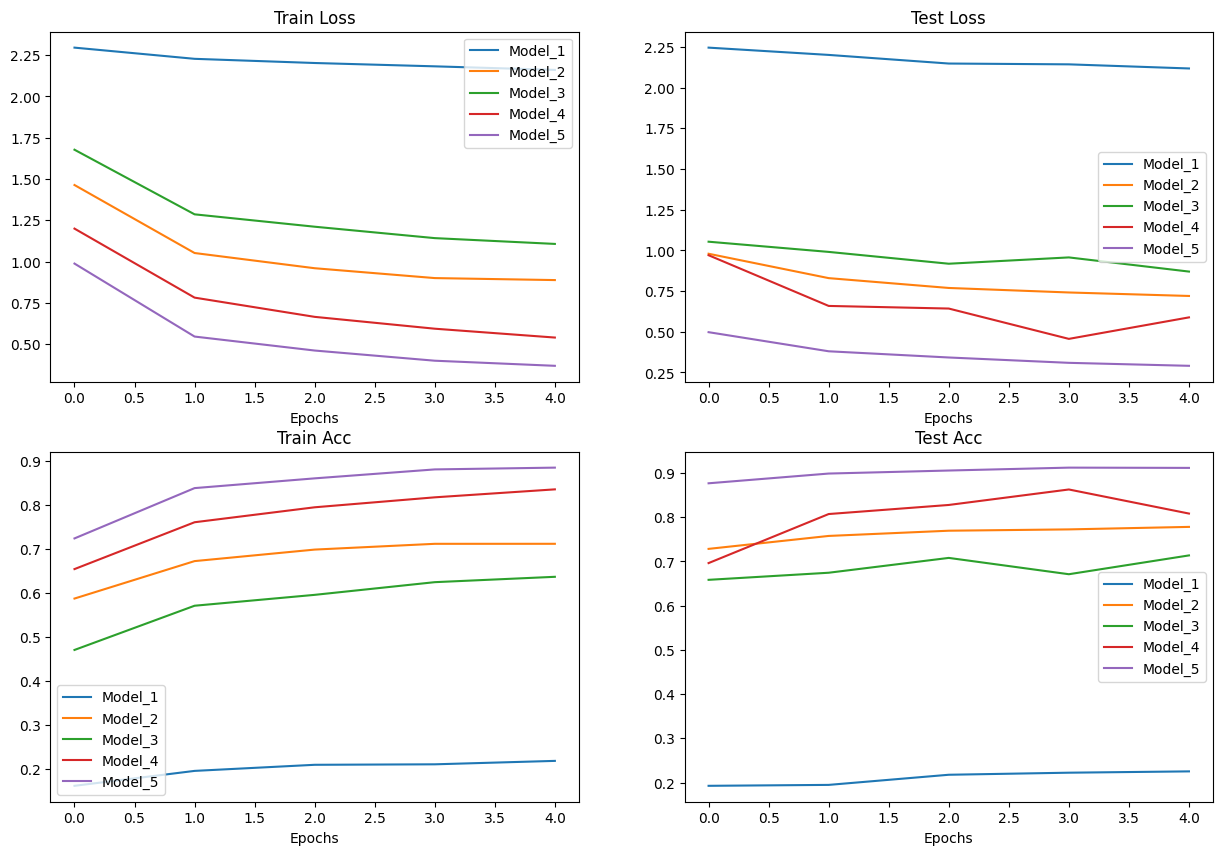

In [ ]:
# Setup a plot
plt.figure(figsize=(15, 10))

# Get number of epochs
epochs = range(len(model_1_df))

# Plot train loss
plt.subplot(2, 2, 1)
plt.plot(epochs, model_1_df["train_loss"], label="Model_1")
plt.plot(epochs, model_2_df["train_loss"], label="Model_2")
plt.plot(epochs, model_3_df["train_loss"], label="Model_3")
plt.plot(epochs, model_4_df["train_loss"], label="Model_4")
plt.plot(epochs, model_5_df["train_loss"], label="Model_5")
plt.title("Train Loss")
plt.xlabel("Epochs")
plt.legend()

# Plot test loss
plt.subplot(2, 2, 2)
plt.plot(epochs, model_1_df["test_loss"], label="Model_1")
plt.plot(epochs, model_2_df["test_loss"], label="Model_2")
plt.plot(epochs, model_3_df["test_loss"], label="Model_3")
plt.plot(epochs, model_4_df["test_loss"], label="Model_4")
plt.plot(epochs, model_5_df["test_loss"], label="Model_5")
plt.title("Test Loss")
plt.xlabel("Epochs")
plt.legend()

# Plot train accuracy
plt.subplot(2, 2, 3)
plt.plot(epochs, model_1_df["train_acc"], label="Model_1")
plt.plot(epochs, model_2_df["train_acc"], label="Model_2")
plt.plot(epochs, model_3_df["train_acc"], label="Model_3")
plt.plot(epochs, model_4_df["train_acc"], label="Model_4")
plt.plot(epochs, model_5_df["train_acc"], label="Model_5")
plt.title("Train Acc")
plt.xlabel("Epochs")
plt.legend()

# Plot test accuracy
plt.subplot(2, 2, 4)
plt.plot(epochs, model_1_df["test_acc"], label="Model_1")
plt.plot(epochs, model_2_df["test_acc"], label="Model_2")
plt.plot(epochs, model_3_df["test_acc"], label="Model_3")
plt.plot(epochs, model_4_df["test_acc"], label="Model_4")
plt.plot(epochs, model_5_df["test_acc"], label="Model_5")
plt.title("Test Acc")
plt.xlabel("Epochs")
plt.legend();

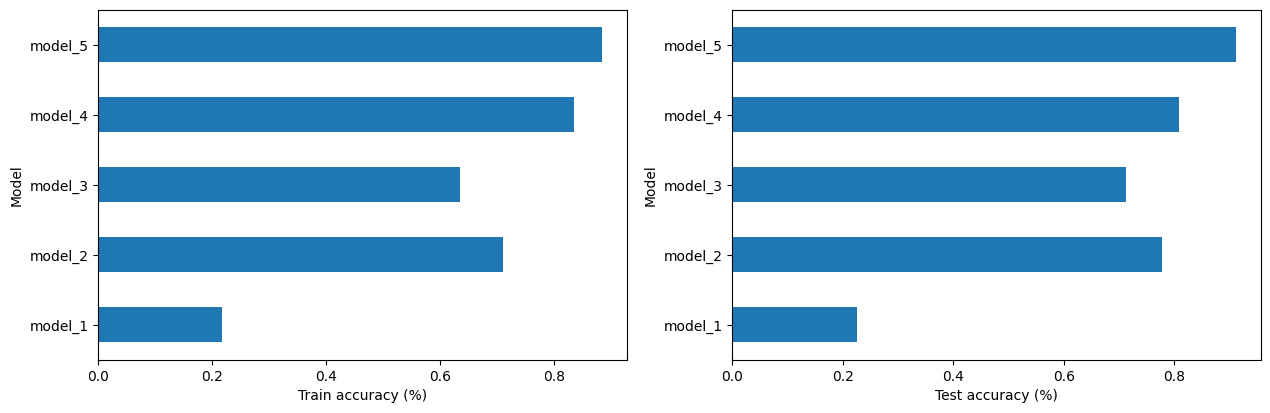

In [ ]:
# Visualise our model results

# Setup a plot
plt.figure(figsize=(15, 10))

plt.subplot(2, 2, 1)
model_comparison_df.set_index("Model")["train_acc"].plot(kind="barh")
plt.xlabel("Train accuracy (%)")
plt.ylabel("Model");

plt.subplot(2, 2, 2)
model_comparison_df.set_index("Model")["test_acc"].plot(kind="barh")
plt.xlabel("Test accuracy (%)")
plt.ylabel("Model");

**Improving model performance**

Methods to improve a model (reduce overfitting):
* More data: Gives a model more of a chance to learn patterns between samples (e.g. if a model is performing poorly on the images of a specific class, show it more images of that class)
* Data augmentation: Increase the diversity of the training dataset without collecting more data (e.g. take the photos of a class and randomly rotate them 30 degrees). Increased diversity forces a model to learn more generalisation patterns.
* Better data: Not all data samples are created equally. Removing poor samples from or adding better samples to the dataset can improve our model's performance.
* Use transfer learning: Take an existing model's pre-learned patterns from one problem and tweak them to suit our own problem.

# 9.Make and evaluate random predictions with best model

Alright, we've compared our models to each other, let's further evaluate our best performing model (which is `model_5` in our case).

To do so, let's create a function `make_predictions()` where we can pass the model and some data for it to predict on.

In [ ]:
def make_predictions(model: torch.nn.Module, data: list, device: torch.device = device):
    pred_probs = []
    model.eval()
    with torch.inference_mode():
        for sample in data:
            # Prepare sample
            sample = torch.unsqueeze(sample, dim=0).to(device) # Add an extra dimension and send sample to device

            # Forward pass (model outputs raw logit)
            pred_logit = model(sample)

            # Get prediction probability (logit -> prediction probability)
            pred_prob = torch.softmax(pred_logit.squeeze(), dim=0) # note: perform softmax on the "logits" dimension, not "batch" dimension (in this case we have a batch size of 1, so can perform on dim=0)

            # Get pred_prob off GPU for further calculations
            pred_probs.append(pred_prob.cpu())

    # Stack the pred_probs to turn list into a tensor
    return torch.stack(pred_probs)

In [ ]:
import random
random.seed(42)
test_samples = []
test_labels = []

# Make predictions only on 9 random samples on the test set
for sample, label in random.sample(list(test_data), k=9):
    test_samples.append(sample)
    test_labels.append(label)

# View the first test sample shape and label
print(f"Test sample image shape: {test_samples[0].shape}\nTest sample label: {test_labels[0]} ({class_names[test_labels[0]]})")

Test sample image shape: torch.Size([3, 256, 256])
Test sample label: 9 (Soup)


And now we can use our `make_predictions()` function to predict on test_samples.

In [ ]:
# Make predictions on test samples with model 5
pred_probs= make_predictions(model=model_5,
                             data=test_samples)

# View first two prediction probabilities list
pred_probs[:2]

tensor([[7.0513e-05, 4.4129e-05, 2.3125e-04, 5.2384e-05, 8.4143e-06, 1.1937e-05,
         2.6108e-05, 8.8212e-06, 1.9664e-05, 9.9952e-01, 3.6557e-06],
        [1.8692e-02, 9.5988e-01, 8.3177e-03, 4.0084e-03, 4.1958e-03, 1.4175e-03,
         2.3277e-06, 3.4844e-05, 2.0815e-03, 9.5866e-04, 4.0804e-04]])

In [ ]:
# Turn the prediction probabilities into prediction labels by taking the argmax()
pred_classes = pred_probs.argmax(dim=1)
pred_classes

tensor([9, 1, 0, 9, 3, 2, 2, 8, 9])

In [ ]:
# Are our predictions in the same form as our test labels?
test_labels, pred_classes

([9, 1, 0, 9, 3, 2, 2, 2, 9], tensor([9, 1, 0, 9, 3, 2, 2, 8, 9]))

Now our predicted classes are in the same format as our test labels, we can compare.

Let's visualise!



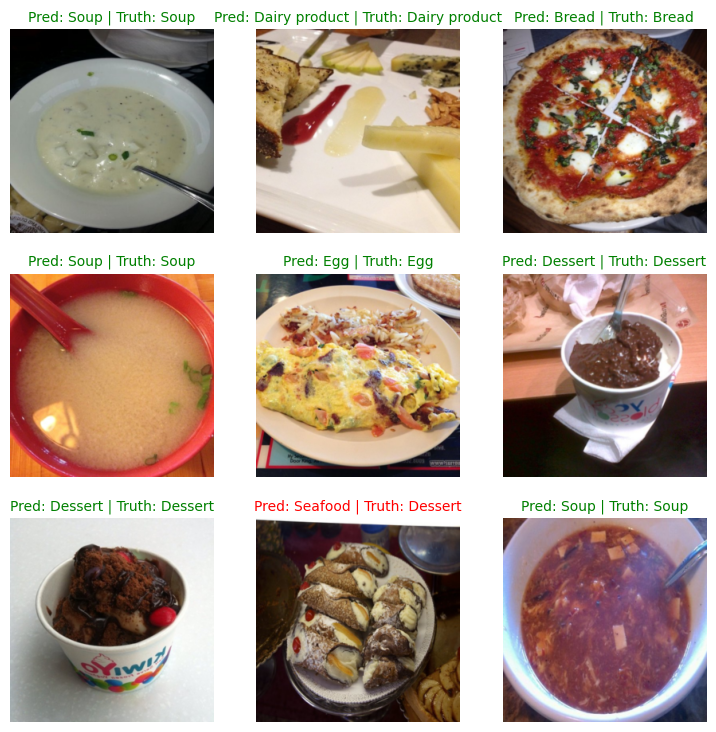

In [ ]:
# Plot predictions
plt.figure(figsize=(9, 9))
nrows = 3
ncols = 3
for i, sample in enumerate(test_samples):
  # Create a subplot
  plt.subplot(nrows, ncols, i+1)

  # Transpose the image dimensions if necessary
  if sample.shape[0] == 3:
    sample = np.transpose(sample, (1, 2, 0))

  # Plot the target image
  plt.imshow(sample)

  # Find the prediction label (in text form, e.g., "soup")
  pred_label = class_names[pred_classes[i]]

  # Get the truth label (in text form, e.g., "noodle")
  truth_label = class_names[test_labels[i]]

  # Create the title text of the plot
  title_text = f"Pred: {pred_label} | Truth: {truth_label}"

  # Check for equality and change title colour accordingly
  if pred_label == truth_label:
      plt.title(title_text, fontsize=10, c="g") # green text if correct
  else:
      plt.title(title_text, fontsize=10, c="r") # red text if wrong
  plt.axis(False);

# 10.Making a confusion matrix for further prediction evaluation

A confusion matrix is a fantastic way of evaluating our classification model visually. A confusion matrix shows us where our classification model got confused between predicitons and true labels.

To make a confusion matrix, we'll go through three steps:

1. Make predictions with our trained model, `model_5` on the test (or evaluation) dataset(a confusion matrix compares predictions to true labels).
2. Make a confusion matrix using `torchmetrics.ConfusionMatrix`.
3. Plot the confusion matrix using `mlxtend.plotting.plot_confusion_matrix()`.

Let's start by making predictions with our best trained model (`model_5`) on the test set.

For further information - Machine Learning with PyTorch and Scikit-Learn (by Sebastian Raschka) - https://sebastianraschka.com/books/

In [ ]:
# Import tqdm for progress bar
from tqdm.auto import tqdm

# 1. Make predictions with our trained model
y_preds = [] # Empty predictions list
model_5.eval()
with torch.inference_mode():
  for X, y in tqdm(test_dataloader_simple, desc="Making predictions..."):
    # Send the data and targets to target device
    X, y = X.to(device), y.to(device)
    # Do the forward pass
    y_logit = model_5(X) # The raw outputs of the model
    # Turn predictions from logits -> prediction probabilities -> prediction labels
    # y_pred = torch.softmax(y_logit, dim=1).argmax(dim=1) # note: perform softmax on the "logits" dimension, not "batch" dimension (in this case we have a batch size of 32, so can perform on dim=1)
    y_pred = torch.softmax(y_logit.squeeze(), dim=0).argmax(dim=1)
    # Put predictions on CPU for evaluation (matplotlib would want them on the CPU to plot them)
    y_preds.append(y_pred.cpu())

# Concatenate list of predictions into a tensor
y_pred_tensor = torch.cat(y_preds)
y_pred_tensor[:10]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Making predictions...:   0%|          | 0/105 [00:00<?, ?it/s]

tensor([0, 9, 3, 7, 8, 4, 5, 9, 2, 8])

In [ ]:
# See if torchmetrics exists and if not, install it
try:
    import torchmetrics, mlxtend
    print(f"mlxtend version: {mlxtend.__version__}")
    assert int(mlxtend.__version__.split(".")[1]) >= 19, "mlxtend verison should be 0.19.0 or higher"
except:
    !pip install -q torchmetrics -U mlxtend # <- Note: If you're using Google Colab, this may require restarting the runtime
    import torchmetrics, mlxtend
    print(f"mlxtend version: {mlxtend.__version__}")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 841.5/841.5 kB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 27.1 MB/s eta 0:00:00
mlxtend version: 0.23.1


In [ ]:
# Import mlxtend upgraded version
import mlxtend
print(mlxtend.__version__)
assert int(mlxtend.__version__.split(".")[1]) >= 19 # should be version 0.19.0 or higher

0.23.1


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Accuracy: 0.9113
Precision: 0.9140
Recall: 0.9135
F1-Score: 0.9134


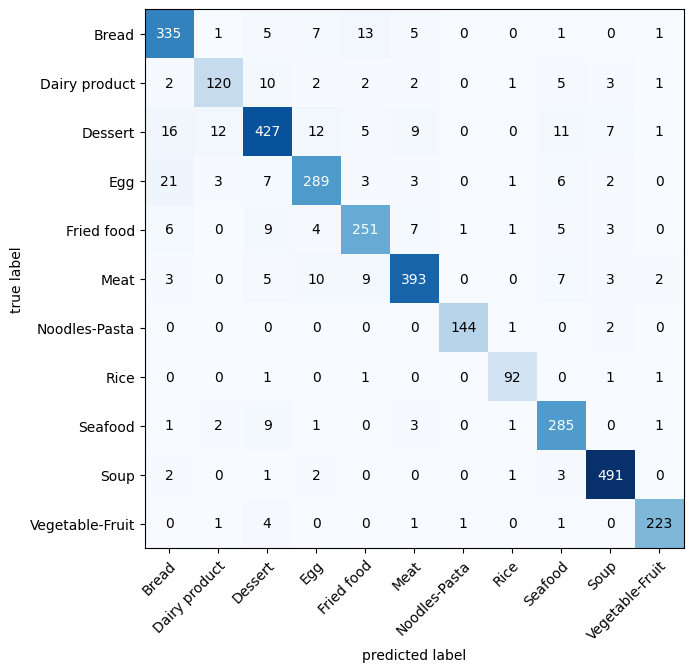

In [ ]:
# Import necessary libraries
import torch
import torchmetrics
from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix
import numpy as np

# Set the model to evaluation mode
model_5.eval()

# Create empty lists to store true and predicted labels
y_true = []
y_pred = []

# Disable gradient calculation for inference
with torch.inference_mode():
    # Iterate over the test or validation dataloader
    for inputs, labels in test_dataloader_simple:
        inputs = inputs.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model_5(inputs)

        # Get the predicted class labels
        _, predicted = torch.max(outputs.data, 1)

        # Append the true and predicted labels to the respective lists
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

# Convert the lists to NumPy arrays
y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Calculate the confusion matrix
conf_mat = confusion_matrix(y_true, y_pred)

# Calculate the metrics
accuracy = torchmetrics.functional.accuracy(torch.tensor(y_pred), torch.tensor(y_true), task='multiclass', num_classes=len(class_names))
precision = torchmetrics.functional.precision(torch.tensor(y_pred), torch.tensor(y_true), task='multiclass', average='macro', num_classes=len(class_names))
recall = torchmetrics.functional.recall(torch.tensor(y_pred), torch.tensor(y_true), task='multiclass', average='macro', num_classes=len(class_names))
f1_score = torchmetrics.functional.f1_score(torch.tensor(y_pred), torch.tensor(y_true), task='multiclass', average='macro', num_classes=len(class_names))

# Print the metrics
print(f"Accuracy: {accuracy.item():.4f}")
print(f"Precision: {precision.item():.4f}")
print(f"Recall: {recall.item():.4f}")
print(f"F1-Score: {f1_score.item():.4f}")

# Plot the confusion matrix
fig, ax = plot_confusion_matrix(
    conf_mat=conf_mat,
    class_names=class_names,
    figsize=(10, 7)
)

In [ ]:
# Get the class distribution
class_counts = np.bincount(y_true)

# Print the number of samples for each class
for class_label, count in enumerate(class_counts):
    print(f"Class {class_names[class_label]}: {count} samples")

Class Bread: 368 samples
Class Dairy product: 148 samples
Class Dessert: 500 samples
Class Egg: 335 samples
Class Fried food: 287 samples
Class Meat: 432 samples
Class Noodles-Pasta: 147 samples
Class Rice: 96 samples
Class Seafood: 303 samples
Class Soup: 500 samples
Class Vegetable-Fruit: 231 samples


**F1-Score per Class:**

The F1-score is the harmonic mean of precision and recall, and it provides a balance between the two metrics. A higher F1-score (closer to 1) is generally better, indicating a good balance between precision and recall.



In [ ]:
from sklearn.metrics import f1_score as sk_f1_score

# We have true labels (y_true) and predicted labels (y_pred)
# as NumPy arrays or lists

# Calculate F1-score for each class
f1_scores = sk_f1_score(y_true, y_pred, average=None)

# Print the F1-score for each class
for class_idx, f1_score in enumerate(f1_scores):
    print(f"Class {class_names[class_idx]}: F1-score = {f1_score:.3f}")

# Calculate the overall F1-score (macro-averaged)
overall_f1 = sk_f1_score(y_true, y_pred, average='macro')
print(f"Overall F1-score: {overall_f1:.3f}")

Class Bread: F1-score = 0.889
Class Dairy product: F1-score = 0.836
Class Dessert: F1-score = 0.873
Class Egg: F1-score = 0.873
Class Fried food: F1-score = 0.879
Class Meat: F1-score = 0.919
Class Noodles-Pasta: F1-score = 0.983
Class Rice: F1-score = 0.948
Class Seafood: F1-score = 0.909
Class Soup: F1-score = 0.970
Class Vegetable-Fruit: F1-score = 0.967
Overall F1-score: 0.913


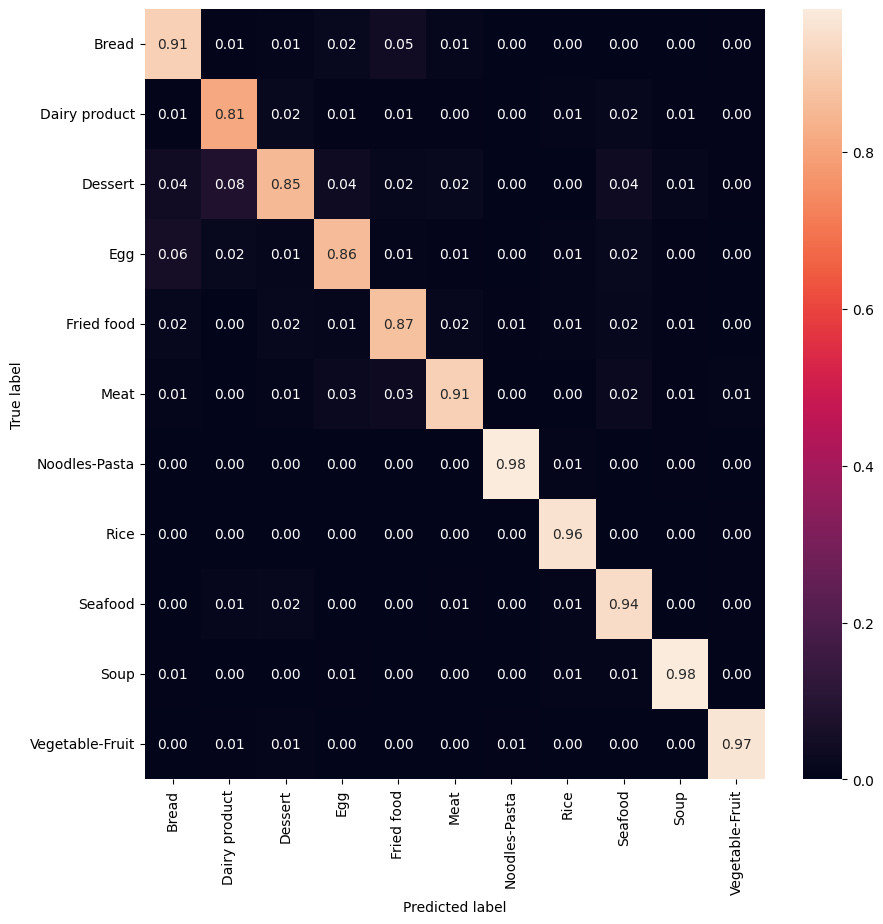

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(y_true, y_pred)
# Normalise
cmn = cm.astype('float') / cm.sum(axis=1)
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(cmn, annot=True, fmt='.2f', xticklabels=class_names, yticklabels=class_names)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()